<a href="https://colab.research.google.com/github/cfong32/kaggle-house-prices/blob/main/proj1f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA*6100 Project 1 -- House Price Prediction

Chung Yan FONG \
Student ID: 1210614 \
chungyan@uoguelph.ca \
2022-Oct-23 (Sun)

# I. Executive Summary

In this project, we have joined [a Kaggle competition to predict house prices](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/description).  Using linear regression, we try to model the house prices by a number of features describing various aspects of residential homes in Ames, Iowa.

1) Based on the standard [Pearson Correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), we are able to locate what the most **price-indicative** features are.

2) With a **cross-validation guided** searching algorithm, we can also determine an **optimal number** of features to be included.

By incorporating both techniques, finally we have built a model using 136 most price-correlated features.  (136 was found to be the optimal number which has achieved the best performance.)  Our implementation was able to predict the prices of 1459 houses on Kaggle's test data with a root-mean-square-logarithmic-error (RMSLE) score of 0.13581.

Our final model suggests that the following five features are the most influential factors to house prices.
- Rates the overall material and finish of the house
- Total square feet of basement area
- Second floor in square feet
- Above ground living area in square feet
- First Floor in square feet

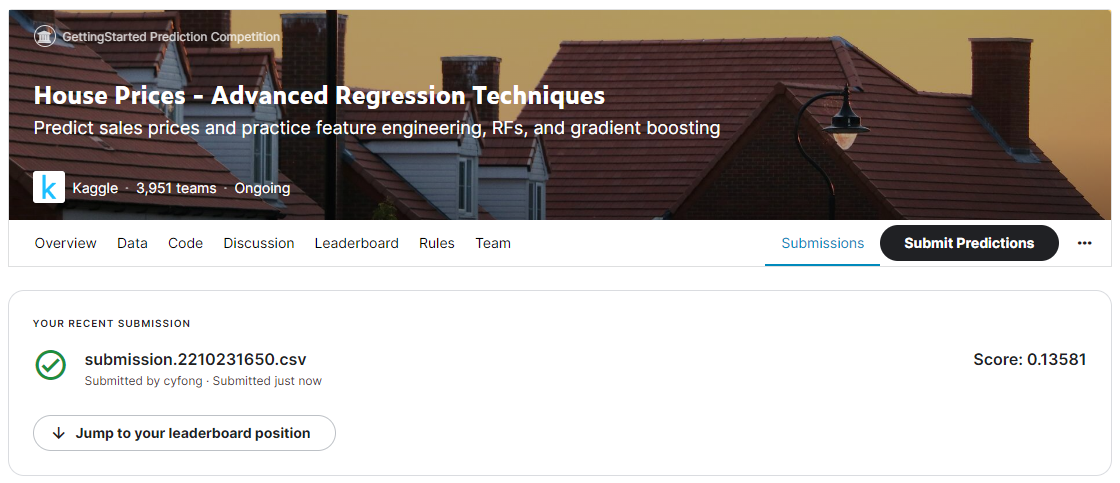

# II. Ethics Discussion

### Privacy concern
The Ames Housing dataset that we use is a public dataset.  It was compiled by Dean De Cock and now is being shared on [Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data) for use in data science education.  The house data is well anonymized, so NO private information of the residents shall leak to the public.

### Bias of the dataset
This dataset may contain bias, so do our experimental results.  For example, the $SalePrice$ of houses sampled from different $Neighborhood$ may have some trends.  Yet such trends shall NOT be used to infer any values or social status of $Neighborhood$ of any kind.

### Purpose of this study
This study was carried out on an *acaedmic purpose*.  The models and training methods that showcased below are NOT intented to suggest prices for commerical use, but ONLY for teaching and learning in statistics, data science or related subjects.

# III. Methodology

### Questions to be Answered

1. Which features are more **indicative**?
    - Out of all 79 available features, which ones are more indicative to house prices ($SalePrice$)?
    
2. **How many** features should we use?
    - Including too few or too many features may not be a good choice.
    - How many of them should we use?  Is there an optimal number that we should pick?

3. How do we input or encode categorical features?

4. What is our target variable?
    - $SalePrice$ or $log(SalePrice)$?

### Our Solution

1. As we are using *linear regression*, features that have *higher correlation* to $SalePrice$ should be less noisy and more indicative.
2. By evaluating the average *cross-validation (CV)* RMSLE at different numbers of features ($F$) used, we are able to locate which $F$ yields the best and robust results.
3. We can encode the categorical features into dummy variables, one per category.  This allows our linear model to capture the effect of the absence or presence of certain categories.
4. We should use $log(SalePrice)$ as our target, because the goal of this Kaggle competition is to minimize the prediction errors to the logarithm of $SalePrice$.

### Why does Pearson correlation (aka correltation) matter?

 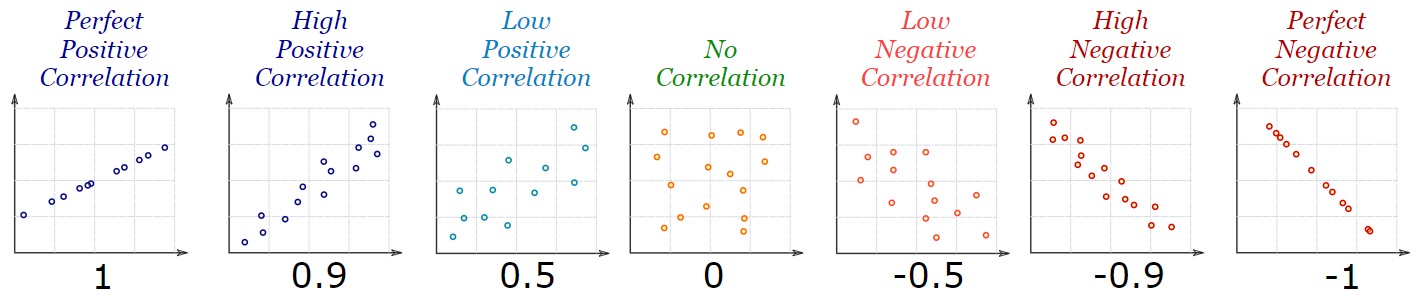[source of image: https://www.mathsisfun.com/data/correlation.html]

*Pearson correltation* ($r$) is one of the common measurement of strength of relationship between two variables.
> "It is a measure of linear correlation between two sets of data".  [Pearson correlation coefficient@Wikipedia](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)

- It ranges from $-1$ to $1$.
- When two variables tend to vary linearly in phase (going up or down together), or in opposite phase (going in reverse directions), their correltation usually result in a *high magnitude*, i.e. $|r|$ will be closer to $1$.
- In contrast, when they are don't have such relations, their correlation will be closer to $0$.

Therefore, from this perspective, if a feature $x$ has a high absolute correlation with the price, $|r(x, SalePrice)|$ or $|r(x, log(SalePrice))|$, it is likely to be a **price-indicative** feature.

# IV. Exploratory Data Analysis

The training dataset contains the prices ($SalePrice$) and 79 explanatory variables (features) describing various aspect of 1460 houses in Ames, Iowa.  Here are some examples:
- Numerical
    - $LotArea$: Lot size in square feet
    - $YearBuilt$: Original construction date
    - $GrLivArea$: Above grade (ground) living area square feet
- Categorical
    - $Street$: Type of road access
    - $Foundation$: Type of foundation
    - $GarageType$: Garage location
    
Detail descriptions of all features can be found [here](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data).

## Prepare the dataset

In [ ]:
###
# import packages
###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge as LinearRegression    # Linear least squares with l2 regularization
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
pd.set_option('display.min_rows', 4)

In [ ]:
###
# Read and show the whole dataset
###

# Please upload the dataset zip file first
# Then run this to unzip it by:
# !unzip -oq house-prices-advanced-regression-techniques.zip

df_train = pd.read_csv('train.csv')
df_test  = pd.read_csv('test.csv')
df = pd.concat([df_train, df_test]).reset_index(drop=True)
df['logSalePrice'] = np.log(df.SalePrice)
display(df)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,logSalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,12.109011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN,NaN
2918,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,11,2006,WD,Normal,NaN,NaN


### Plot the target ($logSalePrice$) distribution

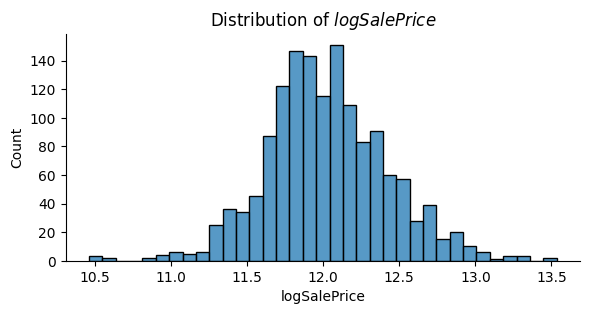

In [ ]:
###
# Plot a histogram of logSalePrice
###

sns.displot(df.logSalePrice, height=3, aspect=2)
plt.title('Distribution of $logSalePrice$')
plt.show()

## Step 1. Find price-indicative features

### Look for features by their correlation with $logSalePrice$

# of numerical features: 36


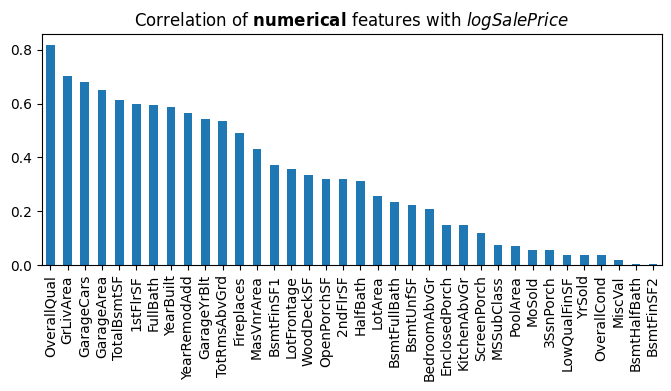

In [ ]:
###
# Plot correlation of numerical features
###

sr_num_features_corr = (
    df.corr(numeric_only=True)['logSalePrice']
    .drop(['Id', 'SalePrice', 'logSalePrice'])
    .abs()
    .sort_values(ascending=False)
)

print(f'# of numerical features: {len(sr_num_features_corr)}')
sr_num_features_corr.plot.bar(figsize=(8,3))
plt.title(r'Correlation of $\bf{numerical}$ features with $logSalePrice$')
plt.show()

# of categorical features: 252


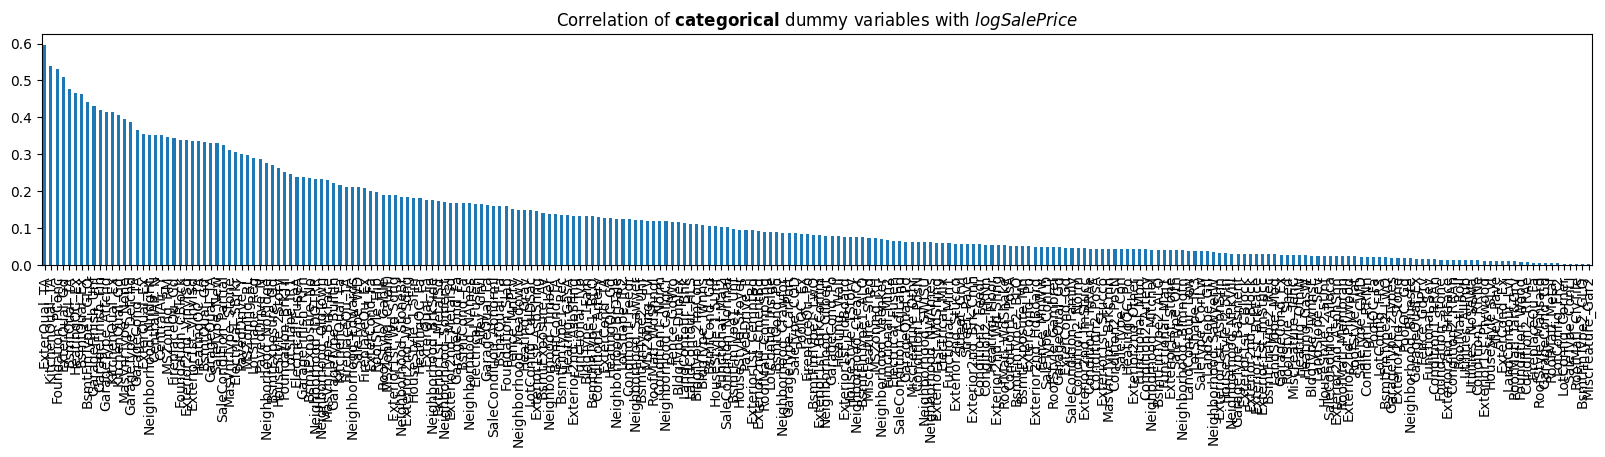

In [ ]:
###
# Plot correlation of categorical features
###

cat_features = df.dtypes[df.dtypes == 'object'].index    # locate all the categorical feature columns
df_cat = pd.get_dummies(df[cat_features])                # convert them into dummy variables

sr_cat_features_corr = (
    df_cat.join(df.logSalePrice)
    .corr()['logSalePrice']
    .drop(['logSalePrice'])
    .abs()
    .sort_values(ascending=False)
)

print(f'# of categorical features: {len(sr_cat_features_corr)}')
sr_cat_features_corr.plot.bar(figsize=(20,3))
plt.title(r'Correlation of $\bf{categorical}$ dummy variables with $logSalePrice$')
plt.show()

### Verify feature quality - do they vary *linearly* with $logSalePrice$?

#### Top-5 numerical features

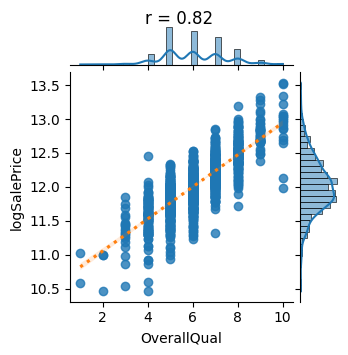

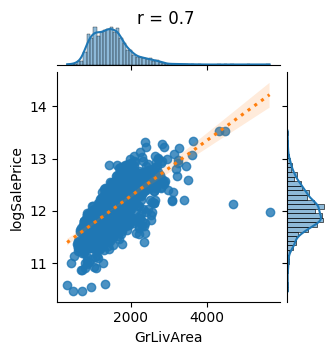

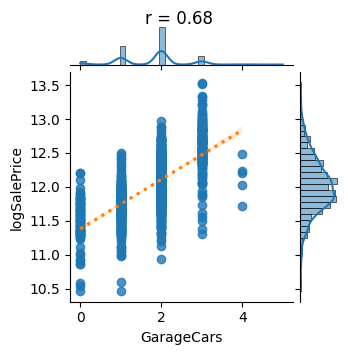

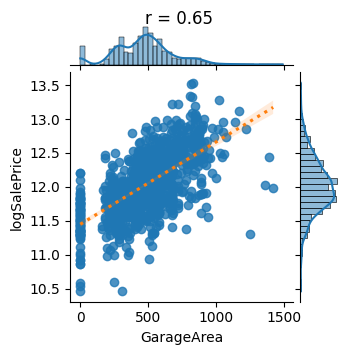

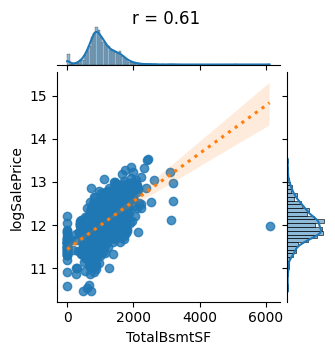

In [ ]:
###
# Plot joint-distributions
# between the mostly correlated *numerical* features
# and $logSalePrice$
###

N = 5
best_num_features = sr_num_features_corr.head(N).index.tolist()
for col in best_num_features:
    sns.jointplot(data=df,
                  x=col,
                  y='logSalePrice',
                  kind='reg',
                  line_kws={'color': 'C1', 'ls': ':'},
                  height=3.5)
    plt.suptitle(f'r = {sr_num_features_corr[col].round(2)}', y=1)
    plt.show()

#### Top-5 categorical features

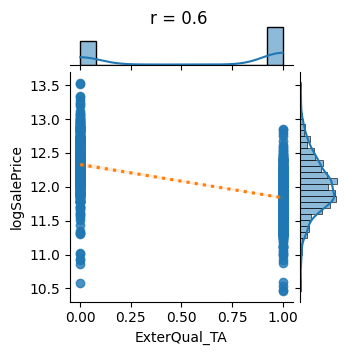

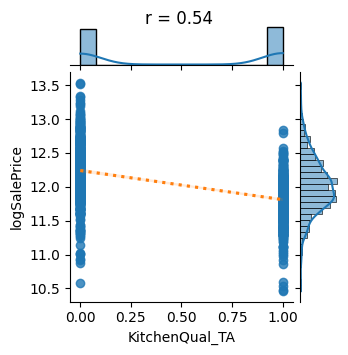

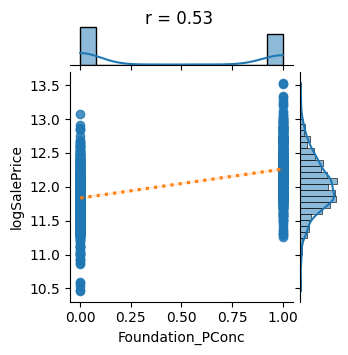

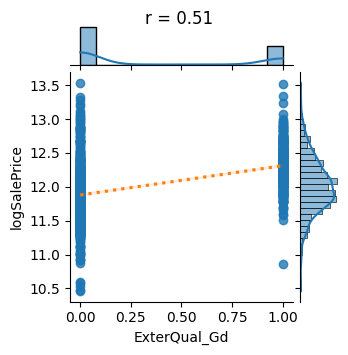

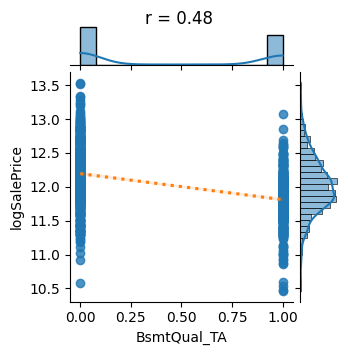

In [ ]:
###
# Plot joint-distributions
# between the mostly correlated *categorical* features
# and $logSalePrice$
###

N = 5
best_cat_features = sr_cat_features_corr.head(N).index.tolist()
for col in best_cat_features:
    sns.jointplot(data=df_cat.join(df.logSalePrice),
                  x=col,
                  y='logSalePrice',
                  kind='reg',
                  line_kws={'color': 'C1', 'ls': ':'},
                  height=3.5)
    plt.suptitle(f'r = {sr_cat_features_corr[col].round(2)}', y=1)
    plt.show()

### Data Preprocessing

- Locating missing values
- Coverting columns to suitable data type
- Coverting categorical features into dummy variables
- Filling NA values on both *training* and *test* set

In [ ]:
###
# Find all missing values in features
###

# We only do it for *numerical* features
sr_missing = df.drop(columns=['Id', 'SalePrice', 'logSalePrice']+list(cat_features)).isna().sum()
sr_missing = sr_missing[sr_missing > 0]
cols_to_fillna = sr_missing.index.tolist()

print('Number of missing values in these columns:')
print(sr_missing)

Number of missing values in these columns:
LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64


In [ ]:
###
# Steps to preprocess data
###

# Reading the dataset again
df_train = pd.read_csv('train.csv')
df_test  = pd.read_csv('test.csv')
df_train['logSalePrice'] = np.log(df_train.SalePrice)

# convecting MSSubClass from int to str
cols_to_str = ['MSSubClass']
for col in cols_to_str:
    df_train[col] = df_train[col].astype(str)
    df_test[col]  = df_test[col].astype(str)

# fillna by median
for col in cols_to_fillna:
    val = df_train[col].median()
    df_train[col] = df_train[col].fillna(val)
    df_test[col]  = df_test[col].fillna(val)

# appending categorical dummy variables
min_occurance = 20
max_occurance = len(df_train) - min_occurance
df = pd.concat([df_train, df_test]).reset_index(drop=True)
cat_features = df.dtypes[df.dtypes == 'object'].index
df_dummy = pd.get_dummies(df_train[cat_features])
sr_dummy_counts = df_dummy.sum()
dummy_features = sr_dummy_counts[(sr_dummy_counts > min_occurance) &
                                 (sr_dummy_counts < max_occurance)].index

df_train = (df_train
            .join(pd.get_dummies(df_train[cat_features])
                  [dummy_features]
                  .fillna(0))
            .drop(columns=cat_features)
)
df_test = (df_test
          .join(pd.get_dummies(df_test[cat_features])
                [dummy_features]
                .fillna(0))
          .drop(columns=cat_features)
)

In [ ]:
###
# drop outliers by clipping at certain lower and upper quantiles.
###

quantile_to_clip = 0.025

cols = [col for col in df_train.columns
        if col not in ['Id', 'SalePrice', 'logSalePrice']]    # select only feature columns

clip_lbounds = df_train[cols].quantile(quantile_to_clip)      # obatin lower bounds
clip_ubounds = df_train[cols].quantile(1-quantile_to_clip)    # obatin upper bounds
df_train[cols] = df_train[cols].clip(clip_lbounds, clip_ubounds, axis=1)    # clip

### Data standardization (*zero-mean-unit-variance*)

In [ ]:
###
# standardize all features, and drop those which fail to convert
###

standardize_mean = df_train[cols].mean()    # mean values to keep
standardize_std  = df_train[cols].std()     # std values to keep

df_train_sd = df_train.copy()
df_train_sd[cols] = (df_train_sd[cols] - standardize_mean) / standardize_std    # standardized version

df_train_sd = df_train_sd.dropna(axis=1)    # drop columns which fails to convert, probably due to zero variance

### Sort feature columns according to their correlations with $logSalePrice$

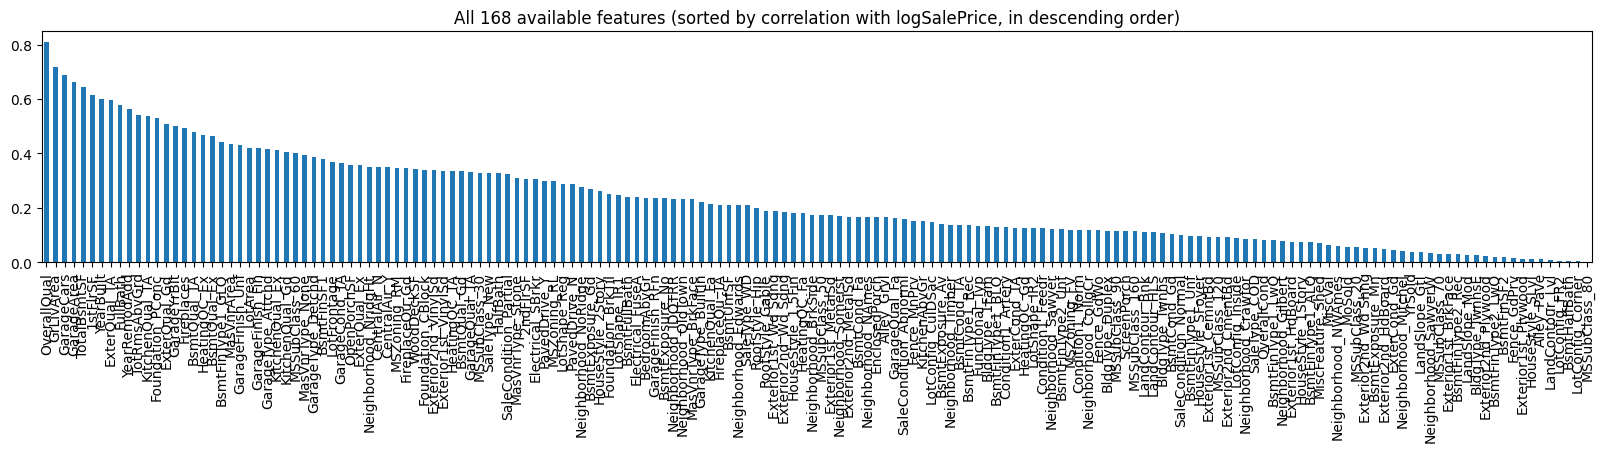

In [ ]:
###
# Sort and plot features
###

sr_all_features_corr = (
    df_train_sd.corr(numeric_only=True)
    ['logSalePrice']
    .abs()
    .drop(['Id', 'SalePrice', 'logSalePrice'])
    .sort_values(ascending=False)
)
sorted_features = sr_all_features_corr.index.tolist()

sr_all_features_corr.plot.bar(figsize=(20,3))
plt.title(f'All {len(sorted_features)} available features (sorted by correlation with logSalePrice, in descending order)')
plt.show()

## Step 2. Determine the *optimal number* ($F$) of features to be included

### Loop through a range of $F$, fitting the model using the top $F$ features

In [ ]:
###
# Fit many models, so as to obtain cross-validation RMSE score as a function of F
###

# F is the number of features to use
N_loop    = 100
N_feature = len(sorted_features)
r = np.exp(np.log(N_feature) / N_loop)
Fs = sorted(set([int(r**i) for i in range(N_loop)]))    # various F to try

Kfold = 11                                              # number of fold to be used in cross-validation

scores = []                                             # results are to be stored here

# Calculate score as a function of F
for F in tqdm(Fs):
    X = df_train_sd[sorted_features[:F]].values
    y = df_train_sd['logSalePrice'].values

    model = LinearRegression()
    cv_scores = -cross_val_score(model,                 # cross-validation
                                 X,
                                 y,
                                 cv=Kfold,
                                 scoring='neg_root_mean_squared_error')
    
    scores.append(np.median(cv_scores))                 # take median CV scores

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 26.62it/s]


best_score: 0.12090710912306751
best_F    : 136


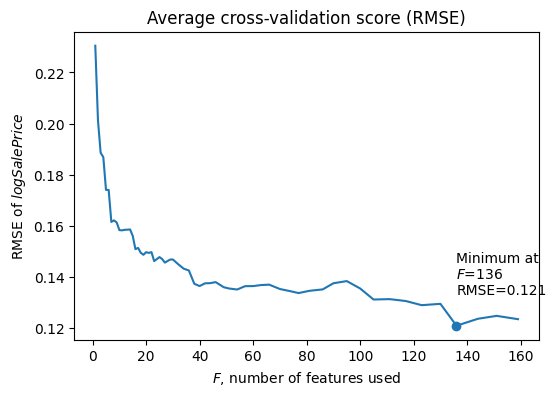

In [ ]:
###
# Analyze and plot cross-validation scores 
###

sr_score = pd.Series(index=Fs, data=scores)
best_F = sr_score.idxmin()
best_score = sr_score.loc[best_F]

print(f'best_score: {best_score}')
print(f'best_F    : {best_F}')

plt.figure(figsize=(6,4))
plt.plot(Fs, scores)
plt.scatter(best_F, best_score)
plt.text(best_F, best_score*1.1, f'Minimum at\n$F$={best_F}\nRMSE={round(best_score, 3)}')
plt.xlabel('$F$, number of features used')
plt.ylabel('RMSE of $logSalePrice$')
plt.title('Average cross-validation score (RMSE)')
plt.show()

# V. Finally, Fit the Best Model using 136 Features

In [ ]:
###
# Fit the final model using all training data
###

F = 136
X = df_train_sd[sorted_features[:F]].values
y = df_train_sd['logSalePrice'].values

model = LinearRegression().fit(X, y)

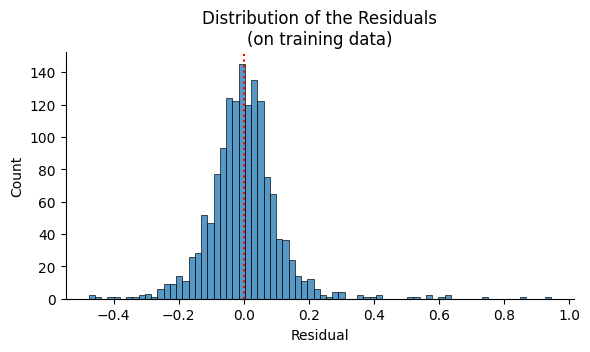

In [ ]:
###
# Plot density of residuals
###

y_hat = model.predict(X)
sns.displot(y_hat-y, height=3, aspect=2)
plt.axvline(0, color='red', ls=':')
plt.title('Distribution of the Residuals\n(on training data)')
plt.xlabel('Residual')
plt.show()

# VII. Model Interpretation

Our linear model has form as follows:

$$
    log(SalePrice) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots +  \beta_F x_F
$$

We will see the coefficients ($\beta_i$) we have obtained for different features ($x_i$), and try to compare their magnitudes with each other.  Since all inputs were standardized to *zero-mean-unit-variance* (or converted to standard scores), we should expect:
- The larger the coefficient $\beta_i$ is, the more influential the features $x_i$ could be (comparing to the population).
- Marginally, when $\Delta x_i = 1$, which is equivalent to a change in the *original value* by *one standard deviation* ($\sigma_i$), it is expected to see that
    - the $log(SalePrice)$ changes by $\beta_i$,
    - thus the $SalePrice$ scales by a factor of $e^\beta$.

When $x_i$ is the only variable:
$$
\begin{align}
\Delta log(SalePrice) &= \beta_i \Delta x_i
\\
\frac{SalePrice + \Delta SalePrice}{SalePrice} &= e^{\beta_i \Delta x_i}
\end{align}
$$

### Model coefficients

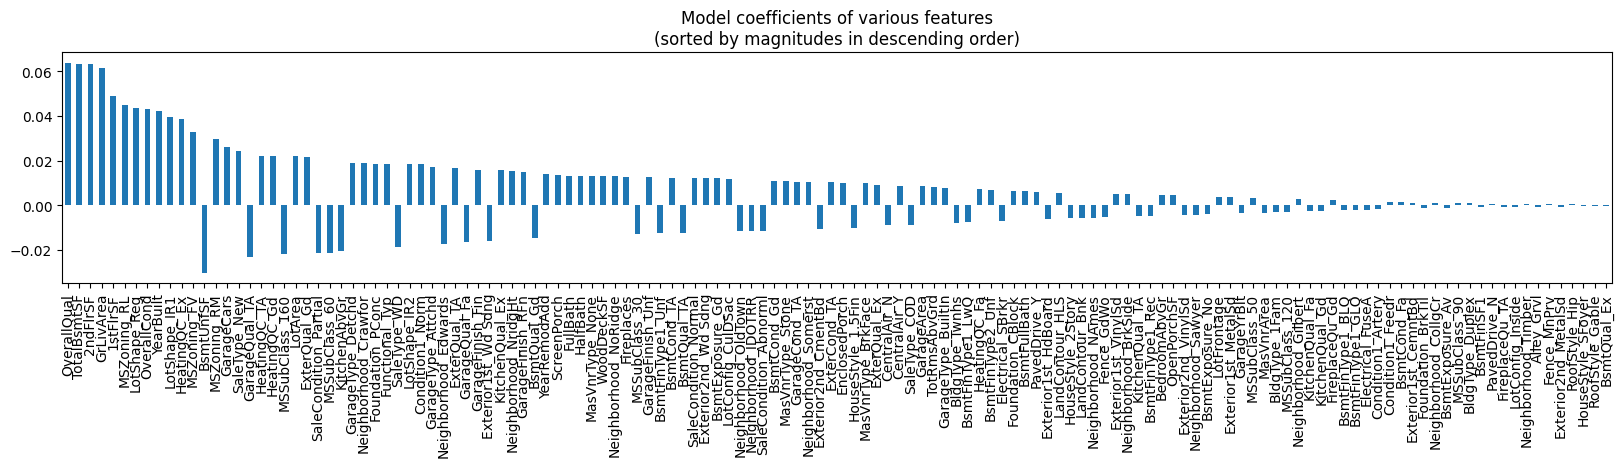

In [ ]:
###
# Plot the model coefficient magnitudes
###

df_coef = pd.Series(index=sorted_features[:F], data=model.coef_)

coef_order = df_coef.abs().sort_values(ascending=False).index.tolist()
df_coef[coef_order].plot.bar(figsize=(20,3))
plt.title('Model coefficients of various features\n'
          '(sorted by magnitudes in descending order)')
plt.show()

### Top-5 feautres

In [ ]:
###
# Tabulate top-K features, coefficients and SD
###

K = 5

print(f'Top-{K} features:')
(df_coef[coef_order[:K]].rename('coef').round(3).to_frame()
 .assign(expcoef=lambda x: np.exp(x.coef).round(3))
 .join(standardize_std[coef_order[:K]].rename('std').round(1))
 .rename(columns={
     'coef'   : r'model coefficient $(\beta_i)$ ↓',
     'expcoef': r'effective scaling in $SalePrice$ $(e^{\beta_i})$',
     'std'    : r'standard deviation observed $(\sigma_i)$',
 })
)

Top-5 features:


,model coefficient $(\beta_i)$ ↓,effective scaling in $SalePrice$ $(e^{\beta_i})$,standard deviation observed $(\sigma_i)$
OverallQual,0.064,1.066,1.3
TotalBsmtSF,0.063,1.065,391.8
2ndFlrSF,0.063,1.065,425.6
GrLivArea,0.062,1.064,474.1
1stFlrSF,0.049,1.050,352.4


### Conclusion

Here are what our model suggests regarding the top-5 features found:
1. $OverallQual$ - Rates the overall material and finish of the house
    - ($e^{\beta_i}=1.066$ and $\sigma_i=1.3$)
    - It suggests a house price increament of 6.6%, for every *overall quality score* increases by 1.3.

1. $TotalBsmtSF$ - Total square feet of basement area
    - ($e^{\beta_i}=1.065$ and $\sigma_i=391.8$)
    - It suggests a house price increament of 6.5%, for every basement area increase of 391.8 sq. feet.
    
1. $2ndFlrSF$ - Second floor square feet
    - ($e^{\beta_i}=1.065$ and $\sigma_i=425.6$)
    - It suggests a house price increament of 6.5%, for every second-floor area increase of 425.6 sq. feet.

1. $GrLivArea$ - Above grade (ground) living area square feet
    - ($e^{\beta_i}=1.064$ and $\sigma_i=474.1$)
    - It suggests a house price increament of 6.4%, for every living area increase of 474.1 sq. feet.

1. $1stFlrSF$ - First Floor square feet
    - ($e^{\beta_i}=1.050$ and $\sigma_i=352.4$)
    - It suggests a house price increament of 5.0%, for every first-floor area increase of 352.4 sq. feet.    

# VIII. Test Prediction for Kaggle Submission

In [ ]:
###
# Standardize test data as in training
###

cols = sorted_features[:F]

df_test_sd = df_test.copy()
df_test_sd[cols] = (df_test_sd[cols] - standardize_mean[cols]) / standardize_std[cols]    # standardized version

In [ ]:
###
# Predict SalePrice for test data
###

X_test = df_test_sd[cols].values
y_test_hat = model.predict(X_test)

df_pred = pd.DataFrame({'Id': df_test_sd.Id, 'SalePrice': np.exp(y_test_hat)})
display(df_pred)

,Id,SalePrice
0,1461,107065.389671
1,1462,164136.665147
...,...,...
1457,2918,118790.855626
1458,2919,220958.273922


In [ ]:
###
# Save submission csv file
###

import pytz
from datetime import datetime, timezone

timestr = datetime.now(pytz.timezone('Canada/Eastern')).strftime("%y%m%d%H%M")

save_path = f'submission.{timestr}.csv'
df_pred.to_csv(save_path, index=False)
print('saved to', save_path)

saved to submission.2210232126.csv
